In [1]:
import pandas as pd
import xarray as xr
import glob
import os
import netCDF4
import scipy
from scipy import stats
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import cartopy as cart
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs
from datetime import datetime, timedelta

In [2]:
#/nfs/public_ads/Oelsmann/marcello/gesla_v2/gesla_v2_northsea_balticsea.nc


region = 'NORTHSEA'

start_time = '01/01/2004'

end_time = '31/12/2004'

if region in {'BALTIC'} :
    max_lat = 66.0
    min_lat = 53.0
    max_lon = 31.0
    min_lon = 9.0
    
    #tg_dac = xr.open_dataset('/nfs/DGFI8/H/work_marcello/giussani_machinelearning_data/TG_DACcorrected/baltic_tg_gesla_dac.nc')
    tg_dac = xr.open_dataset('/nfs/public_ads/Oelsmann/marcello/gesla_v2/gesla_v2_northsea_balticsea.nc')

    lon = np.asarray(tg_dac.lon.values,dtype=float)
    lat = np.asarray(tg_dac.lat.values,dtype=float)    
    
#     # Exclude tide gauges in Kattegat and Skagerrag, because out of the training area

    indices =  ~( (lon < 13.0) & (lon > 9) &   \
                              (lat < 66.0) & (lat > 56.0)) & ((lon < max_lon) & (lon > min_lon) &   \
                              (lat < max_lat) & (lat > min_lat))   
    
    def select_area(tg_dac,lon,lat,min_lon,max_lon,min_lat,max_lat):
        
        indices =  ~( (lon < 13.0) & (lon > 9) &   \
                                  (lat < 66.0) & (lat > 56.0)) & ((lon < max_lon) & (lon > min_lon) &   \
                                  (lat < max_lat) & (lat > min_lat))         
        tg_dac_sel = tg_dac.loc[indices == True]
        
        return tg_dac_sel
    

    # Altimetry
    alti_full = pd.read_csv(r'/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_baltic2004_01to12.csv',index_col=[0],parse_dates=[0])
    alti_full = select_area(alti_full,alti_full.lon,alti_full.lat,min_lon,max_lon,min_lat,max_lat)
    
    #model
    copernicus_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_copernicus.csv',index_col=[7],parse_dates=[7])
    copernicus_full['sla_predicted'] = copernicus_full['sla_predicted'] 
    copernicus_full = select_area(copernicus_full,copernicus_full.lon,copernicus_full.lat,min_lon,max_lon,min_lat,max_lat)

    #cmems
    cmems_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_cmems_allsat.csv',index_col=[5],parse_dates=[5])  
    cmems_full = select_area(cmems_full,cmems_full.lon,cmems_full.lat,min_lon,max_lon,min_lat,max_lat)
    

elif region in {'NORTHSEA'} :
    
    max_lat = 61.0
    min_lat = 50.0
    max_lon = 12.2
    min_lon = -4.0  
    
    tg_dac = xr.open_dataset('/nfs/public_ads/Oelsmann/marcello/gesla_v2/gesla_v2_northsea_balticsea.nc')
    
    lon = np.asarray(tg_dac.lon.values,dtype=float)
    lat = np.asarray(tg_dac.lat.values,dtype=float)
    
    indices =  ( (lon < max_lon) & (lon > min_lon) &   \
                              (lat < max_lat) & (lat > min_lat) )    

    # Altimetry
    alti_full = pd.read_csv(r'/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_northsea2004_01to12.csv',index_col=[0],parse_dates=[0])
    
    #model
    copernicus_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_copernicus.csv',index_col=[7],parse_dates=[7])
    copernicus_full['sla_predicted'] = copernicus_full['sla_predicted'] 

    #cmems
    cmems_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_cmems_NORTHSEA_allsat.csv',index_col=[5],parse_dates=[5])



tg_dac = tg_dac.sel({'x':indices })

In [3]:
#Variance at tide gauges



var_tg=np.empty(np.size(tg_dac.x))*np.nan

for count_TG in tg_dac.x[0:] :
    
    start_lat = np.asarray(tg_dac.lat[count_TG].values,dtype=float)
    start_lon = np.asarray(tg_dac.lon[count_TG].values,dtype=float)

    tide_gauge_name = tg_dac.index[count_TG]
    tg_due = tg_dac
    

    data = {'time':tg_due.time.values,
            'sla_dac':tg_due.sla[:,count_TG]}    
    #break

    # Create DataFrame
    tg = pd.DataFrame(data)
    
    # Remove mean from the tide gauge
    mean_tg_due= tg["sla_dac"].mean()
    tg.sla_dac = tg.sla_dac - tg["sla_dac"].mean()    
    median_tg_due= tg["sla_dac"].median()
    mad_tg_due= tg["sla_dac"].mad()    
    
    # Remove outliers from the tide gauge    
    tg.loc[tg["sla_dac"] > median_tg_due+1.4826*2*mad_tg_due] = np.nan
    tg.loc[tg["sla_dac"] < median_tg_due-1.4826*2*mad_tg_due] = np.nan
    
    tg=tg.set_index(tg.time)
    tg=tg.loc['2004-01-01':'2004-06-15']
    
    tg = tg.groupby(pd.Grouper(freq='24H')).mean()
    
    #var_tg[count_TG]=np.nanstd(tg.sla_dac)
    var_tg[count_TG]=scipy.stats.iqr(tg.sla_dac,nan_policy='omit')
    
    
var_tg_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),var_tg,])


In [4]:
def corr_with_model(groups_reference, groups, var_cmems_plot) :
    
    # This function divides a dataframe "groups" based on the group keys of "groups_reference" and compute the
    # standard deviation of the sea level anomalies for each latitude and longitude
    
    counter = 0
    for group_key, group_value in groups_reference:
        counter = counter+1

        try:
            group = groups.get_group(group_key)
        except:
            continue
        lat_corr_plot = group_key[0]
        lon_corr_plot = group_key[1]    
        
        #var_cmems = np.nanstd(group.sla_predicted)
        var_cmems = scipy.stats.iqr(group.sla_predicted,nan_policy='omit')

        var_cmems_plot[counter-1,:] = np.array([lat_corr_plot,lon_corr_plot,var_cmems])
                
    
    return var_cmems_plot, group



groups_cmems = cmems_full.groupby(['lat', 'lon'])
groups_ML = alti_full.groupby(['lat', 'lon'])
groups_model = copernicus_full.groupby(['lat', 'lon'])


#Variances
var_cmems_plot = np.zeros([np.shape(groups_ML)[0], 3]) * np.nan
var_ML_plot = np.zeros([np.shape(groups_ML)[0], 3]) * np.nan
var_model_plot = np.zeros([np.shape(groups_ML)[0], 3]) * np.nan


counter = 0

# We compute the variability of the sea level at each lat-lon locations, taking the lat-lon locations of the
# Machine Learning dataset as a reference, since these may differ slightly from the CMEMS availability

var_cmems_plot, group \
= corr_with_model(groups_ML, groups_cmems, var_cmems_plot)

var_ML_plot, group \
= corr_with_model(groups_ML, groups_ML, var_ML_plot)

if region in {'BALTIC'} :
    var_model_plot, group \
= corr_with_model(groups_ML, groups_model, var_model_plot)


/home/passaro/anaconda3/envs/machine_learning_altimetry/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


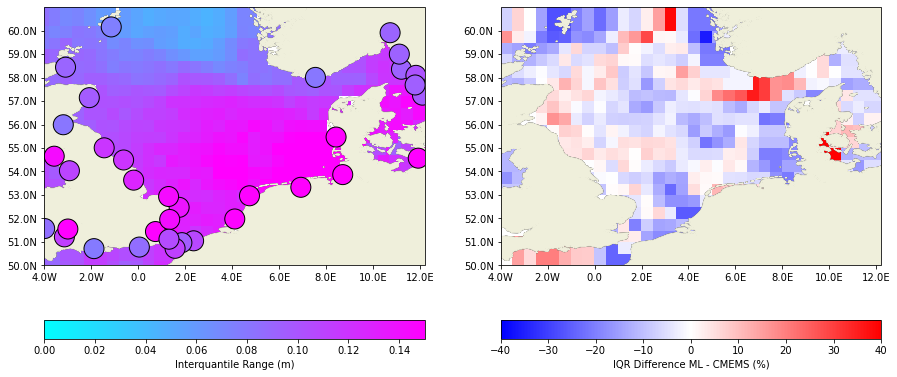

In [20]:
# Variance of Sea Level

fig = plt.figure(figsize = (15, 10))

ax=fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())

ax.set_xticks(np.arange(min_lon,max_lon,2), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(min_lat,max_lat,1), crs=ccrs.PlateCarree())


ax.set_extent([min_lon,max_lon,min_lat,max_lat,])

scat = plt.scatter(var_ML_plot[:,1], var_ML_plot[:,0], c = var_ML_plot[:,2] , edgecolor = 'none', alpha = 1,s=400,
                  vmin=0.8, vmax=1,cmap='cool',marker='s')
if region in {'BALTIC'} :
    plt.clim(0.00, 0.25)
elif region in {'NORTHSEA'} : 
    plt.clim(0.00, 0.15)

scat_due = plt.scatter(var_tg_plot[0,:], var_tg_plot[1,:], c = var_tg_plot[2,:] , edgecolor = 'black', alpha = 1,s=400,
                  vmin=0.8, vmax=1,cmap='cool',marker='o',zorder=2)
if region in {'BALTIC'} :
    plt.clim(0.00, 0.25)
elif region in {'NORTHSEA'} : 
    plt.clim(0.00, 0.15)

lon_formatter = cart.mpl.ticker.LongitudeFormatter(number_format='.1f', 
                                  degree_symbol='', 
                                  dateline_direction_label=True)
lat_formatter = cart.mpl.ticker.LatitudeFormatter(number_format='.1f', 
                                 degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter) 
plt.colorbar(scat,label=r'Interquantile Range (m)',orientation = 'horizontal',pad = 0.1)

ax.coastlines(resolution='10m', color='black', linewidth=1) 
#ax.fillcontinents(color='coral',lake_color='aqua')
import cartopy.feature as feature
ax.add_feature(feature.LAND,zorder=1)

#plt.colorbar(scat_due,label=r'Variance (m^2)')
#plt.colorbar().set_label(r'Interquantile Range (m)')


#####################################################################

ax=fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())

ax.set_xticks(np.arange(min_lon,max_lon,2), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(min_lat,max_lat,1), crs=ccrs.PlateCarree())


ax.set_extent([min_lon,max_lon,min_lat,max_lat,])

scat = plt.scatter(var_cmems_plot[:,1], var_cmems_plot[:,0], c = (var_ML_plot[:,2] - var_cmems_plot[:,2])/var_cmems_plot[:,2]*100, edgecolor = 'none', alpha = 1,s=900,
                  vmin=0.8, vmax=1,cmap='bwr',marker='s')
plt.clim(-40, 40)


lon_formatter = cart.mpl.ticker.LongitudeFormatter(number_format='.1f', 
                                  degree_symbol='', 
                                  dateline_direction_label=True)
lat_formatter = cart.mpl.ticker.LatitudeFormatter(number_format='.1f', 
                                 degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter) 
plt.colorbar(scat,label=r'IQR Difference ML - CMEMS (%)',orientation = 'horizontal',pad = 0.1)

ax.coastlines(resolution='10m', color='black', linewidth=1) 
#ax.fillcontinents(color='coral',lake_color='aqua')
import cartopy.feature as feature
ax.add_feature(feature.LAND,zorder=1)

#plt.colorbar(scat_due,label=r'Variance (m^2)')
#plt.colorbar().set_label(r'IQR Difference ML - CMEMS (%)')

fig.savefig("fig_variance.png")


In [7]:
if region in {'BALTIC'} :

    # Variance of Sea Level - vs model

    fig = plt.figure(figsize = (15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree()) 

    ax.set_xticks(np.arange(min_lon,max_lon,2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(min_lat,max_lat,1), crs=ccrs.PlateCarree())


    ax.set_extent([min_lon,max_lon,min_lat,max_lat,])

    scat = plt.scatter(var_cmems_plot[:,1], var_cmems_plot[:,0], c = (var_cmems_plot[:,2] - var_model_plot[:,2]), edgecolor = 'none', alpha = 1,s=900,
                      vmin=0.8, vmax=1,cmap='bwr',marker='s')
    plt.clim(-0.10, 0.10)


    lon_formatter = cart.mpl.ticker.LongitudeFormatter(number_format='.1f', 
                                      degree_symbol='', 
                                      dateline_direction_label=True)
    lat_formatter = cart.mpl.ticker.LatitudeFormatter(number_format='.1f', 
                                     degree_symbol='')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter) 

    ax.coastlines(resolution='10m', color='black', linewidth=1) 
    #ax.fillcontinents(color='coral',lake_color='aqua')
    import cartopy.feature as feature
    ax.add_feature(feature.LAND,zorder=1)

    #plt.colorbar(scat_due,label=r'Variance (m^2)')
    plt.colorbar().set_label(r'IQR Difference ML - Model (m)')